#  AlexNet Inspired Architecture for CIFAR10 data
# Author: Huygens Ravelomanana
# Description
We build an AlexNet inspired architecture and train it on the CIFAR10 dataset.<br>
We report the training history and evaluate the model on a test data.<br>
This was done **using GPU**.

# Importing libraries

In [1]:
%matplotlib inline
# to store the plots within the notebook

# uncomment this line below if running on google colab
%tensorflow_version 2.x 

import random 
# setting seed for random in order to get reproducible results

import itertools  

# to clear memory
# cuda help connect python with the GPU
#from numba import cuda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

random.seed(1)    # python random seed
np.random.seed(1)  # numpy random seed

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D,
                                     Lambda, Flatten,
                                     Dense, Dropout,
                                     BatchNormalization)

from tensorflow.keras import initializers
from tensorflow.keras.optimizers import (SGD, Adam, Nadam,
                                         Adagrad, RMSprop, Adadelta)

from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set(style="whitegrid")


In [2]:
# checking if tf is using GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data - data exploration

In [3]:
# loading the data train and test sets from tensorflow dataset minst
# we load the data into /tmp partition
# we will split the main mnist train data further in train and validation
# that's why we use X_train_val y_train_val here instead of X_train, y_train
(X_train_val, y_train_val), (X_test, y_test) = cifar10.load_data()


170508288/170498071 [==============================] - 11s 0us/step


In [4]:
# splitting train_val data into train and validation
# to reduce randomness in the training we will provide validation_data
# instead of just a validation_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=1/10,
                                                  shuffle=True,
                                                  random_state=1)

# converting the target class vector into binary class matrix
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [5]:
# checking the shape of the data
print("\nTrain features shape: ", X_train.shape)
print("Train target shape: ",y_train.shape,"\n")
print("Validation features shape: ", X_val.shape)
print("Validation target shape: ", y_val.shape, "\n")
print("Test features shape: ", X_test.shape)
print("Test target shape: ", y_test.shape, "\n")


Train features shape:  (45000, 32, 32, 3)
Train target shape:  (45000, 10) 

Validation features shape:  (5000, 32, 32, 3)
Validation target shape:  (5000, 10) 

Test features shape:  (10000, 32, 32, 3)
Test target shape:  (10000, 10) 



### Comment
+ From the shape we can see that we have 10 different classes.
+ We do not need to reshape the data since it is already 4D.


### Printing some images
+ The "object" corresponding to the different labels of `X_train_val` are:

|      0     |      1     |      2     |      3     |     4     |     5     |      6     |     7     |     8     |      9      |
|:----------:|:----------:|:----------:|:----------:|:---------:|:---------:|:----------:|:---------:|:---------:|:-----------:|
| airplane   | automobile | bird       | cat        | deer      | dog       | frog       | horse     | ship      | truck       |

+ Source [https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html)

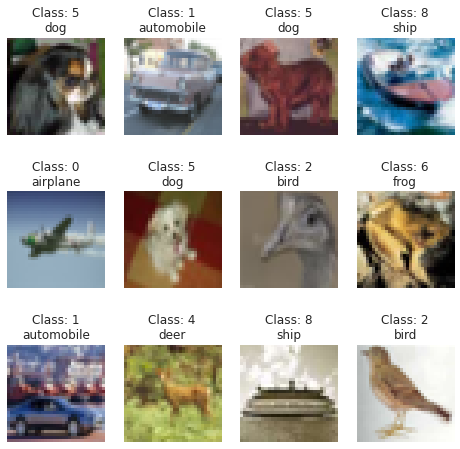

In [6]:
# printing random images from X_train_val

# defining some variable
# in case we make the printing into a function later
features_data = X_train_val
label_data = y_train_val
n_sample = features_data.shape[0]

# creating a dictionary for the label name
name_dic = {0: 'airplane', 1: 'automobile',
            2: 'bird', 3: 'cat',
            4: 'deer', 5: 'dog',
            6: 'frog', 7: 'horse',
            8: 'ship', 9: 'truck'}

# creating axis for the plot
fig, axes = plt.subplots(3, 4, figsize=(8,8))

# flattening the axis array into 1D
axes = axes.ravel()

for i in range(12):
    # random index for train data
    index = random.randint(0,n_sample-1)

    # getting the numerical label 0, 1, 2, ..., 9
    num_label = label_data[index][0]

    # getting the actual name: airplane, ...., truck
    name = name_dic[num_label]

    # showing the image
    axes[i].imshow(features_data[index],  interpolation='none')

    # set title as the corresponding label
    axes[i].set_title('Class: {}\n{}'.format(num_label, name))

    # not showing the axis (we just want to see image)
    axes[i].axis('off')
        
# show the figure
plt.show()


In [7]:
# looking at the max and min value of the training features.
print("minimum value: ", X_train.min(), "\n",
      "maximum value: ", X_train.max())

minimum value:  0 
 maximum value:  255


# Data preprocessing
As the original AlexNet was designed for 227 x 227 images instead of 32 x 32, to compensate we are going to:
+ Scale the input to $[0, 1]$ (as usual)
+ Do data augmentation in order to make the model more robust to noise.

## Scalling the input
+ We are going to scale all the images so that the values fall in the $[0,1]$ range instead of the $[0,255]$.<br> This is in order to make the weights small.

In [8]:
#scaling all images in the datasets
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [9]:
# checking the shape of the data
print("\nTrain features shape: ", X_train.shape)
print("Validation features shape: ", X_val.shape)
print("Test features shape: ", X_test.shape)



Train features shape:  (45000, 32, 32, 3)
Validation features shape:  (5000, 32, 32, 3)
Test features shape:  (10000, 32, 32, 3)


In [10]:
# checking the new max and min value of the training features.
print("minimum value: ", X_train.min(), "\n",
      "maximum value: ", X_train.max())

minimum value:  0.0 
 maximum value:  1.0


## Data augmentation

In [11]:
# we are going to rotate shift and flip some images
rotation=20
width_shift = 3/32
height_shift = 3/32
flip = True

# creating an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=rotation,
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )

# fitting the ImageDataGenerator instance
datagen.fit(X_train)

# creating the features iterator to be used for training
train_iterator = datagen.flow(X_train, y_train, shuffle=True) 

# Creating the model and doing the training

### The AlexNet model

+ which follows the original configuration: [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

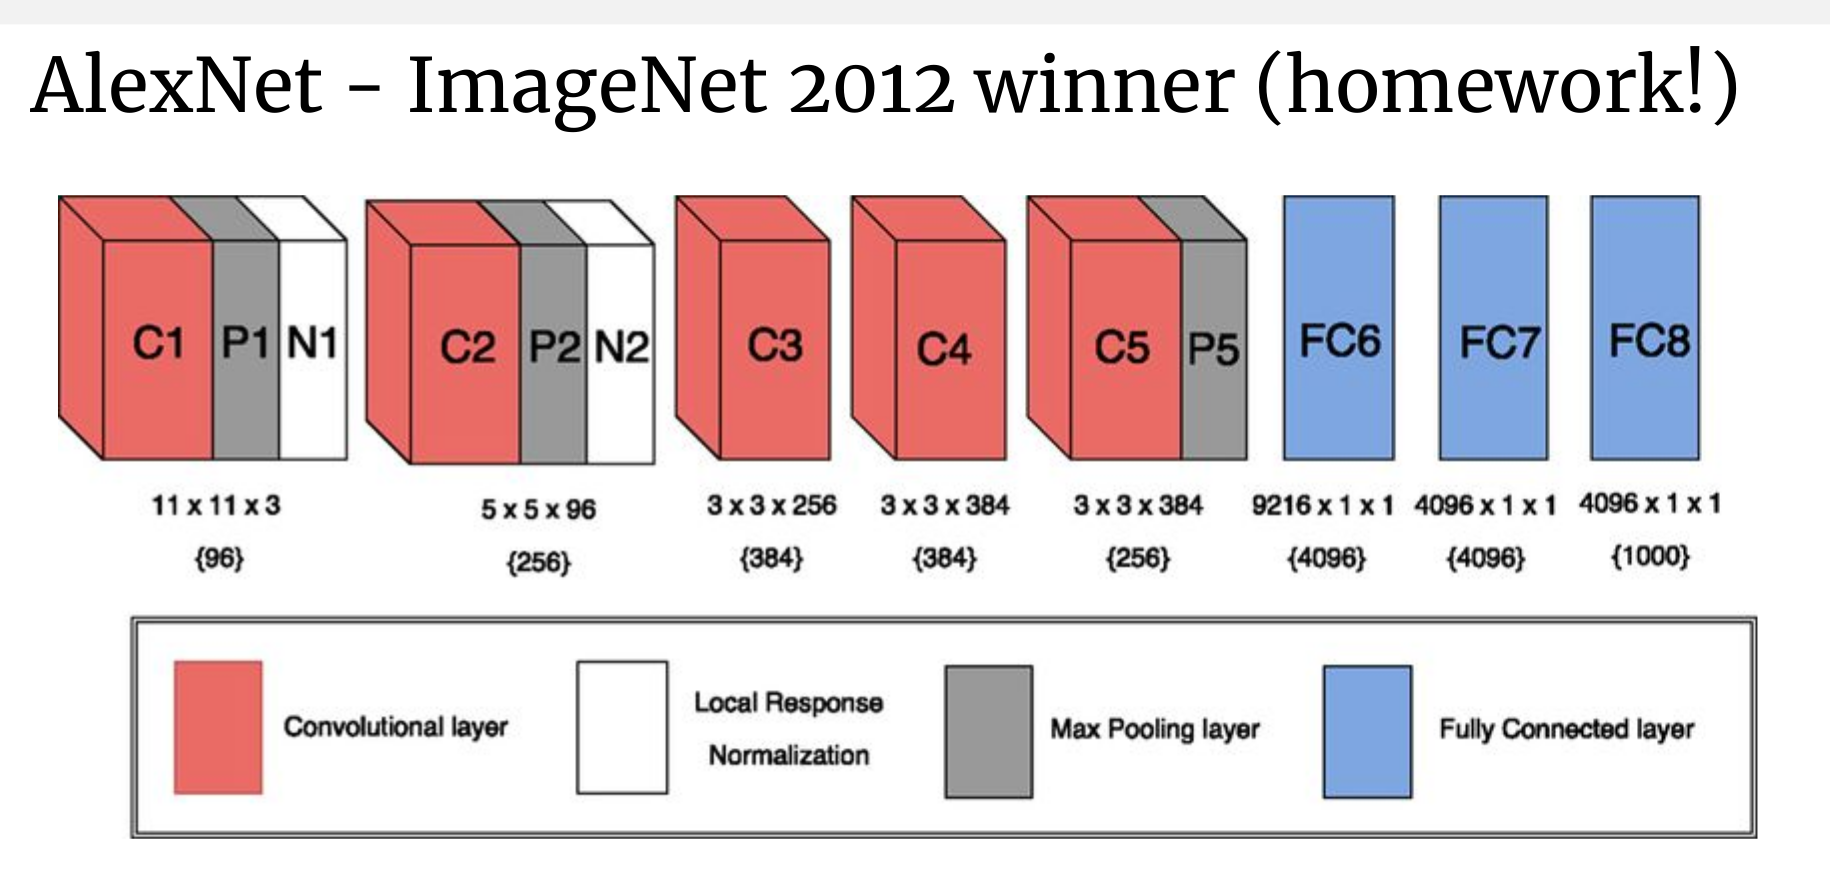

+ Tabular summary
    * The original AlexNet configuration is the following

|     Layer    |                              | Feature Map  |    Size/Shape      |  Kernel size   |     Stride    |   Activation   |
|:------------:|:----------------------------:|:------------:|:------------------:|:--------------:|:-------------:|:--------------:|
|   Input      |           Image              |       1      | ( _ , 227, 227, 3) |        -       |       -       |        -       |
|      C1      |          Convolution         |      96      |          -         |      11 x 11     |       1       |      relu      |
|      P1      |          Max Pooling         |      -      |          -         |      5 x 5     |       2       |      relu      |
|      N1      | Local Response Normalization |      -      |          -         |        -       |       -       |      -      |
|      C2      |          Convolution         |      256     |          -         |      3 x 3     |       1       |      relu      |
|      P2      |          Max Pooling         |      -     |          -         |      3 x 3     |       2       |      relu      |
|      N2      | Local Response Normalization |      -     |          -         |        -       |       -       |      -      |
|      C3      |          Convolution         |      384     |          -         |      3 x 3     |       1       |      relu      |
|      C4      |          Convolution         |      384     |          -         |      3 x 3     |       1       |      relu      |
|      C5      |          Convolution         |      256     |          -         |      3 x 3     |       1       |      relu      |
|      P5      |          Max Pooling         |      -     |          -         |      3 x 3     |       2       |      relu      |
|      FC6     |     Fully Connected Layer    |     4096     |          -         |        -       |       -       |      relu      |
|      FC7     |     Fully Connected Layer    |     4096     |          -         |        -       |       -       |      relu      |
| Output / FC8 |     Fully Connected Layer    |     1000     |          -         |        -       |       -       |     softmax    |


### Explanation of our approach / version of the model
#### **Some hyperparameters choices**
+ Using the knowledge of the best combinations of hyperparameters from previous projects,<br>
we did random shearch (from grid) CV using variation our homework 2 (code similar to the search for local response normalization hyperparameters) to find the following best value for some hyperparameters:
    * learning rate =  0.0001
    * initializer for the Neural Network part = lecun_normal
    * batch_size = 12
    * optimizer = Nadam,   with `beta_1 = 0.75` and `beta_2 = 0.8`
+ We did a random (grid) search CV to find the "best" values for the local response normalization hyperparameters are:
    * depth_radius = 7
    * bias = 0.6
    * alpha = 0.06
    * beta = 0.5

+ By simple trial and error, we found that the best initializer for the convolution
part is: lecun_uniform

Due do the non-systematic nature of these searches, these values may not be the universally best one but they did provide about 85% test accuracy when used together.

#### **About the structure of our model**

+ Instead of the original one we choose more adapted filter sizes since our images are 32 x 32.

+ We also reduced the sizes of the neural netwrok part since the original values were too big. We chose our layer size by simple trial and error taking into account the size of the input obtained from the convolution part and that our images are 7 or 6 times smaller.

The original AlexNet configuration is prone to overfitting if used on the CIFAR10 dataset so the rest of our effort was toward controlling this overfitting. In particular to control the training loss decay (and accuracy progress) so that they are smooth (not noisy) and as close to the validation loss and accuracy as possible. A consequence of this is that we had to train for more number of epochs than in the previous homeworks and for a longer amount of time.

+ To control overfitting we first added  l2 regularization for the weights /kernel (filter matrices), biases, and activity for :
    * The first layer of convolution C1.
    * The 2 firsts neural network layers FC6 and FC7
+ The choice of the regularization hyperparameters was done by trial and error and by considering the commonly used ones.

+ After the regularization we added some batch normalization in both the convolution part and the neural network part.

+ We then added a learning rate scheduler as callback together with early stopping but we chose the patience to be suffficiently large since our model is learning slowly.

+ After all the above we found that it was acceptable to keep the original  layer sizes for the convolution part. Instead of changing them we added some dropouts to improve the model further.

Using random ("grid") search cv in some of the steps above would have probably provided better choices and result (90% test accuracy and above) but we had limited time and resources.



## Utility functions for the model creation and training and for the training evaluation



In [12]:

# function for creating and compiling the model
def create_alexnet(lr, initializer, optimizer, lr_norm_param):
    """Creating and compiling a cnn model using keras.models.Sequential().
    INPUT:
    ------
          lr (str): value of the learning rate in string. The learning rate
              will be directly used by the optimizer parameter and will not
              be seen in this code. It is passed as a parameters so that the
              variable lr appears in this function local  scope of variable.
            
          initializer (str): string values for tf.keras.initializers classes.
          
          optimizer (str): to be evaluated by the built in eval() function.
                     must be one of tf.keras.optimizers optimizer classes
                     when evaluated, the corresponding class must have been
                     properly imported in the python session.
        
        lr_norm_param (tuple): 4-tuple (depth_radius, bias, alpha, beta)
                    hyperparameters for the local response normalization.
    
    OUTPUT:
    -------
          model (tensorflow.python.keras.engine.sequential.Sequential):
                 the compiled model
    """

    # unpacking the local response normalization hyperparameters
    depth_radius, bias, alpha, beta = lr_norm_param

    # defining a local response normalization function
    lr_norm = tf.nn.local_response_normalization
    local_resp_norm = lambda _ : lr_norm(_, 
                                         depth_radius=depth_radius,
                                         bias=bias,
                                         alpha=alpha,
                                         beta=beta)
    
    ################# AlexNet Model  ##############################

    # creating an instance of keras Sequential class
    model = Sequential()

    # first block of layers C1, P1, N1
    # ================================

    # convolution layer C1
    model.add(Conv2D(96, (3, 3),
                     strides=(1, 1),
                     activation='relu',
                     input_shape=(32, 32, 3),
                     kernel_initializer='lecun_uniform',
                     kernel_regularizer=regularizers.l2(1e-1),
                     bias_regularizer=regularizers.l2(1e-1),
                     activity_regularizer=regularizers.l2(1e-2)))

    # max pooling layer / downsampling P1
    model.add(MaxPool2D((2,2),
                        strides=(2, 2),
                        padding='same'))

    # local response normalization layer N1
    model.add(Lambda(local_resp_norm,
                name="local_response_normalization_1"))

    # second block of layers C2, P2, N2
    # =================================

    # convolution layer C2
    model.add(Conv2D(384, (2, 2), 
                     strides=(1, 1),
                     activation='relu',
                     kernel_initializer='lecun_uniform'))

    # adding batch normalization
    model.add(BatchNormalization())

    # max pooling layer / downsampling P2
    model.add(MaxPool2D((2,2),
                        strides=(2, 2),
                        padding='same')) 


    # local response normalization layer N2
    model.add(Lambda(local_resp_norm,
                     name="local_response_normalization_2"))


    # third block of layers C3, C4, C5, P5
    # ====================================
    
    # convolution layer C3
    model.add(Conv2D(384, (2, 2), 
                     strides=(1, 1),
                     activation='relu', 
                     kernel_initializer='lecun_uniform'))
    
    # adding batch normalization
    model.add(BatchNormalization())

    # convolution layer C4
    model.add(Conv2D(256, (2, 2), 
                     strides=(1, 1),
                     activation='relu',
                     kernel_initializer='lecun_uniform'))
    
    # adding batch normalization
    model.add(BatchNormalization())

    # convolution layer C5
    model.add(Conv2D(256, (2, 2), 
                     strides=(1, 1),
                     activation='relu',
                     kernel_initializer='lecun_uniform'))
    
    # adding batch normalization
    model.add(BatchNormalization())

    # max pooling layer / downsampling P5
    model.add(MaxPool2D((2,2),
                        strides=(2, 2),
                        padding='same')) 

    # adding dropout
    model.add(Dropout(0.2))

    # last block of layers / neural network: FC6, FC7, FC8
    # ==================================================
    
    # flatten the tensor into 1D array
    model.add(Flatten())

    # batch normalization
    model.add(BatchNormalization()) # comment for 87%

    model.add(Dropout(0.2))

    # input layer FC6
    model.add(Dense(512,
                    activation='relu',
                    kernel_initializer=initializer,
                    kernel_regularizer=regularizers.l2(2e-1),  
                    bias_regularizer=regularizers.l2(2e-1),
                    activity_regularizer=regularizers.l2(1e-2))
                    )

    # batch normalization
    model.add(BatchNormalization())

    # dropping out some neurons
    model.add(Dropout(0.7))

    # hidden layer FC7
    model.add(Dense(640,
                    activation='relu',
                    kernel_initializer=initializer,
                    kernel_regularizer=regularizers.l2(3e-1),
                    bias_regularizer=regularizers.l2(3e-1),
                    activity_regularizer=regularizers.l2(1e-2)) 
                    )

    # output layer FC8
    model.add(Dense(10,
                    activation='softmax',
                    kernel_initializer=initializer))


    ################### End of Model #################################

    # compiling the model
    # ======================
    model.compile(optimizer=eval(optimizer),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [13]:
# defining a learning rate scheduler function
def scheduler(epoch, lr):
    """ Learning rate scheduler
    INPUT:
    ------         
          epochs (int): current number of epoch.

          lr (float): initial learning rate
    
    OUTPUT:
    -------
          history (tensorflow.python.keras.callbacks.History): History for the
                 model training
    """

    if epoch < 20:  # changed from 8 20:33
        return lr
    else:
        return lr * tf.math.exp(0.08*(20-epoch))



In [14]:
# function fitting a model with an iterator
def fit_model_gen(model, train_iterator, batch_size, epochs):
    """Fitting the model model given as parameters.
    INPUT:
    ------
          model (tensorflow.python.keras.engine.sequential.Sequential):
                    an already compiled keras Sequential model with
                    different layers            

          train_iterator (NumpyArrayIterator): the train data as an iterator.

          batch_size (int): batch size to be used during each epoch of training.
          
          epochs (int): number of epochs for the training.
    
    OUTPUT:
    -------
          history (tensorflow.python.keras.callbacks.History): History for the
                 model training
          
          test_results: result of the testing on the test data
          
    """

    # setting random seed to get reproducible results
    random.seed(1)    # python random seed
    np.random.seed(1)  # numpy random seed
    tf.random.set_seed(1) # tensorflow global random seed
    tf.compat.v1.set_random_seed(1) # tensorflow graph level random seed

    # we are using early stopping callback to prevent the model from
    # training for more epochs than needed, it will save time and resources.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=8)

    # learning rate scheduler
    lambda_scheduler = lambda _ : scheduler( _ , lr)
    lr_sched = LearningRateScheduler(lambda_scheduler)

    # fitting the model
    # we use the globally defined train and validation data
    history = model.fit(train_iterator,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[lr_sched, early_stop],
                        shuffle=True,
                        verbose=0)
    
    return history, model



In [15]:
# Creating a function which plots loss or accuracy curve
def plot_train_val_curves(history):
    """Function plotting the train and validation loss and accuracy curves
    INPUT:
    -----   
            history (tensorflow.python.keras.callbacks.History):
                     output of the .fit() method of a keras Model instance
    OUTPUT:
    ------
            None (it shows some plots)
    """

    # creating figure and axis for the plot
    fig, axes = plt.subplots(1,2, figsize=(20,8))

    # train and validation loss plot
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Loss Progress During Training', fontsize=15)
    axes[0].set_ylabel('Training and Validation Loss', fontsize=12)
    axes[0].set_xlabel('Epoch number', fontsize=12)
    axes[0].legend(['Training Loss', 'Validation Loss'], fontsize=12)

    # train and validation accuracy plot
    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title('Model accuracy Progress During Training', fontsize=15)
    axes[1].set_ylabel('Training and Validation accuracy', fontsize=12)
    axes[1].set_xlabel('Epoch number', fontsize=12)
    axes[1].legend(['Training accuracy', 'Validation accuracy'], fontsize=12)

    plt.show()



## Finding the best hyperparameters

In [42]:
# defining a function for fitting the model

#def fit_model(model, lr, batch_size, epochs):
def fit_model(model, batch_size, epochs, Xtrain, ytrain):
    """Fitting the model model given as parameters.
    INPUT:
    ------
          model (tensorflow.python.keras.engine.sequential.Sequential):
                    an already compiled keras Sequential model with
                    different layers            
          
          batch_size (int): batch size to be used during each epoch of training.
          
          epochs (int): number of epochs for the training.
    
    OUTPUT:
    -------
          history (tensorflow.python.keras.callbacks.History): History for the
                 model training
          
          test_results: result of the testing on the test data
          
    """

    # setting random seed to get reproducible results
    random.seed(1)    # python random seed
    np.random.seed(1)  # numpy random seed
    tf.random.set_seed(1) # tensorflow global random seed
    tf.compat.v1.set_random_seed(1) # tensorflow graph level random seed

    # we are using early stopping callback to prevent the model from
    # training for more epochs than needed, it will save time and resources.
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=4)
    # learning rate scheduler
    lambda_scheduler = lambda _ : scheduler( _ , lr)
    lr_sched = LearningRateScheduler(lambda_scheduler)

    # fitting the model
    # we use the globally defined train and validation data
    history = model.fit(Xtrain, ytrain,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[lr_sched, early_stop],
                        shuffle=True,
                        verbose=0)
    
    return history, model



### Creating lists of hyperparameters

In [43]:
# we tried multiple lists
# removing the "worst" values progressively
# the lists below if the last of them and offer the best performance
# 

depth_radius_list =[7]
bias_list=[0.6, 0.5, 0.4]
alpha_list = [2e-1, 1e-1, 6e-2, 5e-2]
beta_list= [0.4, 0.5, 0.6]


# lists of possible values for some layer size
c1_layer = [64, 96]
fc6_layers = [128, 256, 300, 512]
fc7_layers = [64, 128, 256]

In [44]:
# creating the different possible combinations of  hyperparameters based
# on our 4 lists of hyperparameters values.
hyperparameters_iter = itertools.product(depth_radius_list,
                                         bias_list,
                                         alpha_list,
                                         beta_list)

#hyperparameters_iter = itertools.product(c1_layer,
#                                         fc6_layers,
#                                         alpha_list,
#                                         fc7_layers)

# itertools.product() returns an iterator so we have to convert it into a list
hyperparameters_list = list(hyperparameters_iter)


In [45]:
# checking the number of hyperparameters
len(hyperparameters_list)

36

### Randomly choosing 10 different combinations among all the possible one

In [46]:
# using random.sample to randomly pick 10 hyperparameters combinations
# out of all the possible one in parameters_list

# setting seed for random in order to get reproducible results
random.seed(1)
random_hyperparameters = random.sample(hyperparameters_list, 10)

# looking at the samples
random_hyperparameters = random_hyperparameters + [(7, 0.5, 0.5, 0.5)]
random_hyperparameters

[(7, 0.6, 0.06, 0.6),
 (7, 0.6, 0.1, 0.5),
 (7, 0.5, 0.1, 0.5),
 (7, 0.6, 0.06, 0.5),
 (7, 0.4, 0.06, 0.5),
 (7, 0.4, 0.2, 0.4),
 (7, 0.5, 0.2, 0.6),
 (7, 0.5, 0.1, 0.4),
 (7, 0.5, 0.06, 0.6),
 (7, 0.5, 0.2, 0.4),
 (7, 0.5, 0.5, 0.5)]

### Creating and training the 10 models based on the previously sampled combinations

In [47]:
%%time
# magic command for getting the execution time of the this cell



# setting random seed to get reproducible results
random.seed(1)    # python random seed
np.random.seed(1)  # numpy random seed
tf.random.set_seed(1) # tensorflow global random seed
tf.compat.v1.set_random_seed(1) # tensorflow graph level random seed


# creating a dictionary  to keep track of training of each model
# the keys of the dictionary will be hyperparameters combinations
histories = {}

# creating a dictionary to keep track of the test result for each model
# same keys as above
test_dic = {}

# dictionary of all the models
model_dic = {}

# looping through all the randomly choosen combination of hyperparameters
# creating and  training the corresponding model
#for hyperparameters in random_hyperparameters:
for hyperparam in random_hyperparameters:
    
    # Removes all data from previous models (freeing memory)
    K.clear_session()

    # more step for clearing memory if using GPU
    #cuda.select_device(0)
    #cuda.close()

    # other hyperparameters
    lr = 0.0001
    initializer = 'lecun_normal'
    batch_size = 12
    optimizer = 'Nadam(learning_rate=lr, beta_1=0.75, beta_2=0.8)'
    
    # creating and compiling the corresponding model
    model = create_alexnet(lr, initializer, optimizer, hyperparam)
    
    # fitting / trainig the model
    history, model = fit_model(model,
                           batch_size,
                           epochs=200,
                           Xtrain=X_train,
                           ytrain=y_train)

    # Evaluating the model on the test data
    # we choose a fix batch size for the evaluation
    test_results = model.evaluate(X_test, y_test,
                                batch_size=64,
                                verbose=0)
    
    # saving training history in a pandas DataFrame
    histories[hyperparam] = pd.DataFrame(history.history,
                                              index=history.epoch)
    
    # saving the test result for the corresponding 
    # hyperparameters combination
    test_dic[hyperparam] = test_results

    # saving the model in a dictionary
    model_dic[hyperparam] = model
    
    print("Training done for: ", hyperparam, end='\n')


Training done for:  (7, 0.6, 0.06, 0.6)
Training done for:  (7, 0.6, 0.1, 0.5)
Training done for:  (7, 0.5, 0.1, 0.5)
Training done for:  (7, 0.6, 0.06, 0.5)
Training done for:  (7, 0.4, 0.06, 0.5)
Training done for:  (7, 0.4, 0.2, 0.4)
Training done for:  (7, 0.5, 0.2, 0.6)
Training done for:  (7, 0.5, 0.1, 0.4)
Training done for:  (7, 0.5, 0.06, 0.6)
Training done for:  (7, 0.5, 0.2, 0.4)
Training done for:  (7, 0.5, 0.5, 0.5)
CPU times: user 1h 28min 30s, sys: 4min 42s, total: 1h 33min 12s
Wall time: 1h 27min 5s


### Comparing the 10 different models
+ We will visualize the curves of:
    * training loss and training accuracy first
    * then the curves of validation loss and validation accuracy
+ We will look more closely at the corresponding dataframes for better insight
+ Finally we will look at the test results

In [48]:
# Creating a function which plots loss or accuracy curve
def plot_curves(type_of_plot, title, ylabel):
    """Function plotting loss or accuracy (depending on type_of_plot parameter)
    for the 12 different combinations of hyperparameters.

    INPUT:
    -----   
            type_of_plot (str): the possible values are
                        'loss' (training loss),
                        'accuracy' (training accuracy)
                        'val_loss'(validation loss),
                        'val_accuracy' (validation accuracy).

            title (str): the title of the plot.

            ylabel (str), ylabel for the plot.

    OUTPUT:
    ------
            None (it shows a plot)
    """

    # color palette to be used for the 12 different curves
    color_palette = sns.color_palette("tab20", n_colors=12)

    ## creating figure and axis for the plot
    # creating axis for the plot
    loss_figure = plt.figure(figsize=(10, 10))
    axes = loss_figure.gca()
    axes.set_title(title, fontsize=15)
    axes.set_ylabel(ylabel, fontsize=15)
    axes.set_xlabel('Epoch number', fontsize=15)

    # looping through all the randomly choosing combination of hyperparameters 
    # and plotting the corresponding curves
    for hyperparameters, color in zip(random_hyperparameters, color_palette):

        axes.plot(histories[hyperparameters][type_of_plot],
                color=color,
                label=hyperparameters,
                linewidth=3)

    # adding legend to the plot
    axes.legend(loc='upper right', bbox_to_anchor=(2.3, 1), fontsize=15)
    axes.set_xticks(list(range(0, 21, 2)))

    plt.show()


#### Training loss and accuracy vs epoch for the 10 models

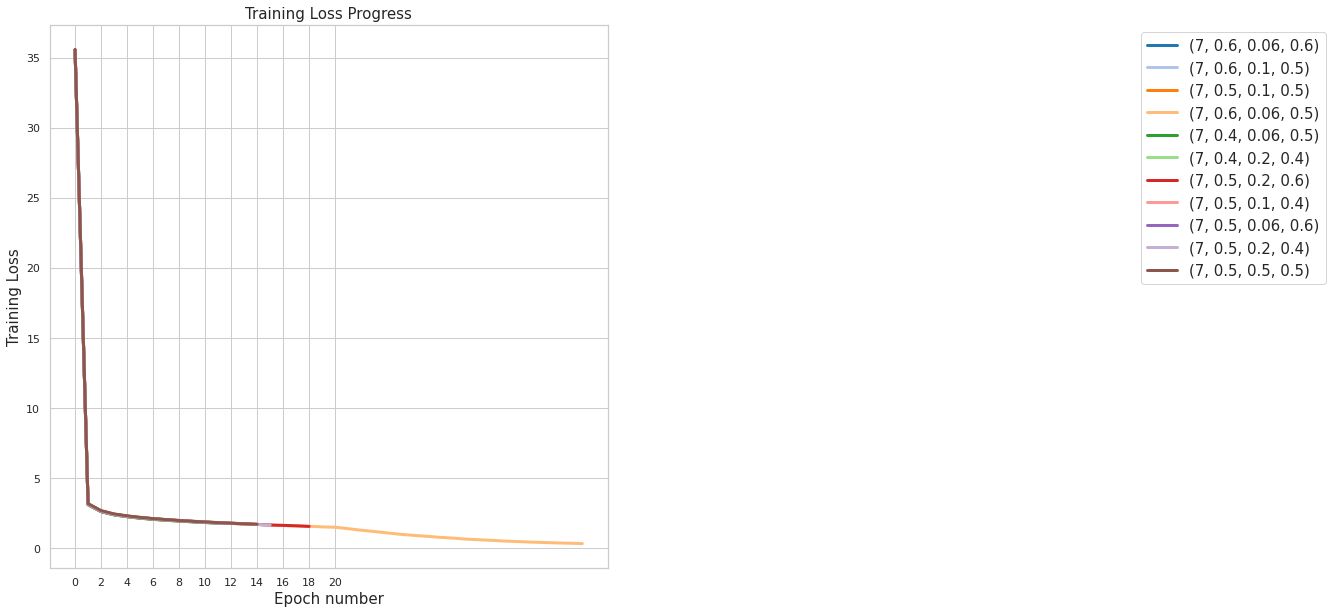

In [49]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of training loss vs epochs for the 12 models
plot_curves('loss', 'Training Loss Progress', 'Training Loss')

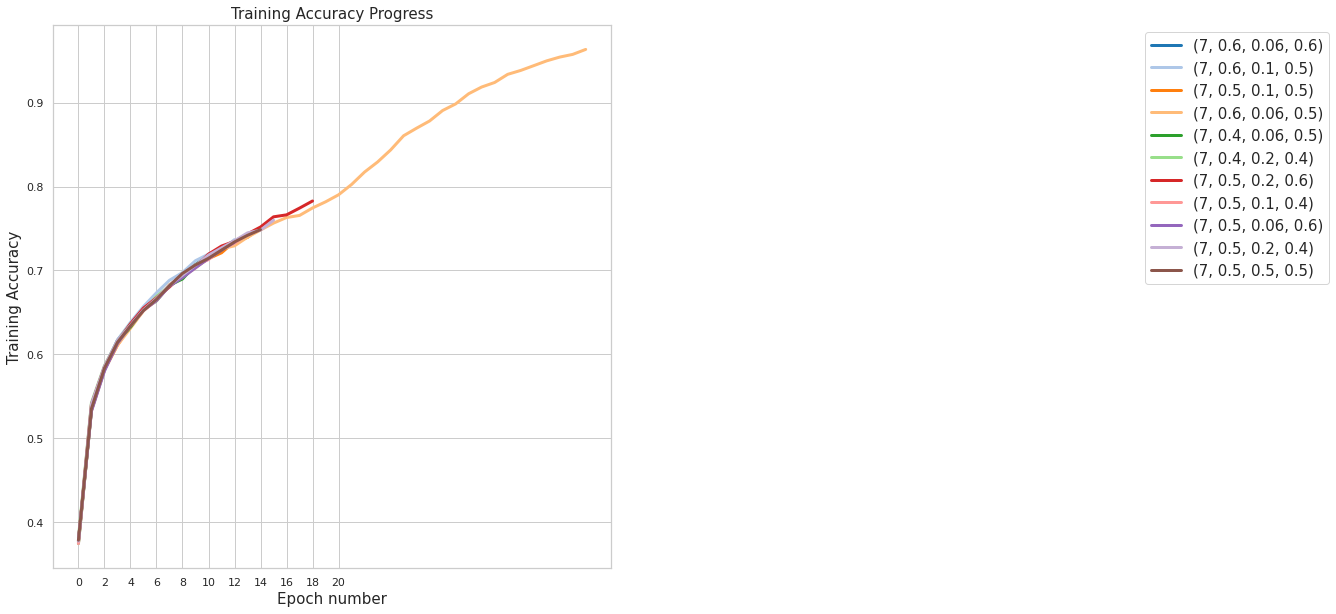

In [50]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of training accuracy vs epochs for the 12 models
plot_curves('accuracy',
            'Training Accuracy Progress',
            'Training Accuracy')

#### Validation loss and accuracy vs epoch for the 10 models

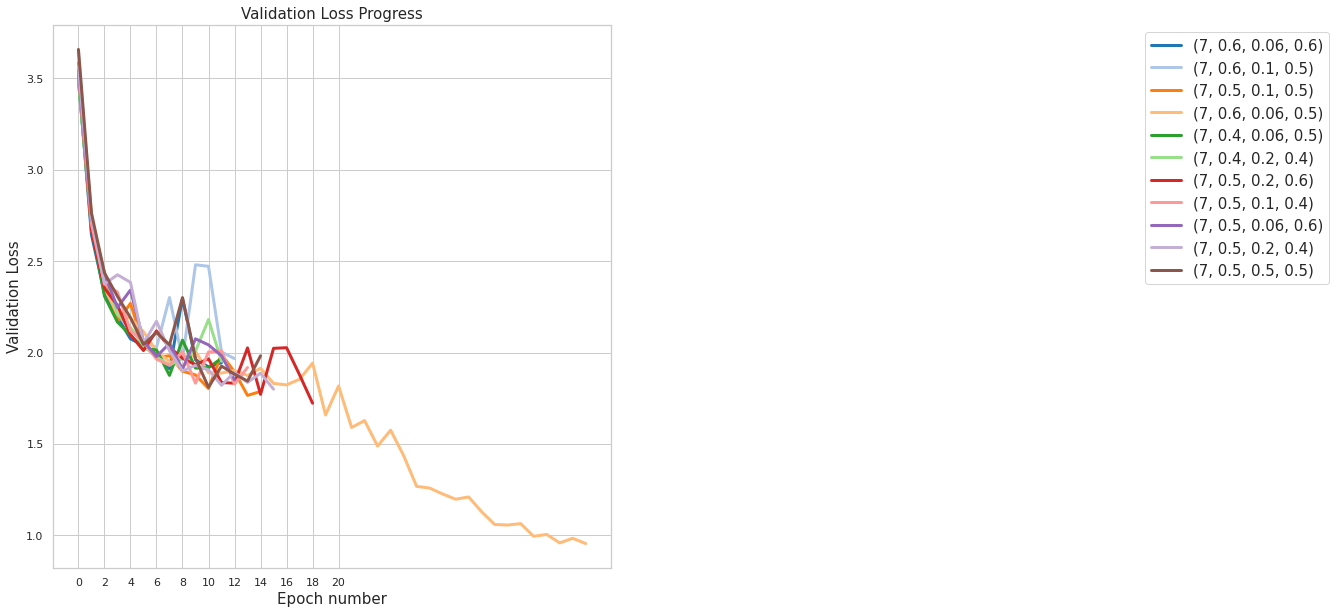

In [51]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of validation loss vs epochs for the 12 models
plot_curves('val_loss', 'Validation Loss Progress', 'Validation Loss')

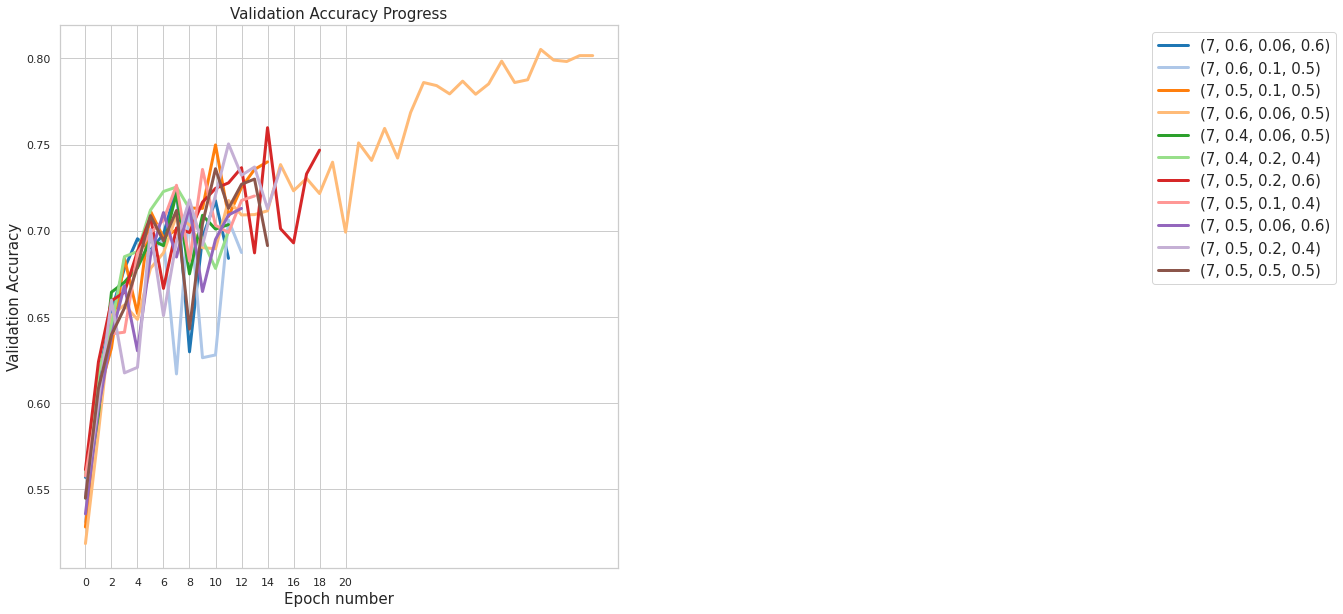

In [52]:
%matplotlib inline
# to store the plots within the notebook

# plotting the curves of validation accuracy vs epochs for the 12 models
plot_curves('val_accuracy',
            'Validation Accuracy Progress',
            'Validation Accuracy')

#### Last  epoch accuracy for the 10 different models
+ We do this to better understand the pictures  above.

In [53]:
# creating a pd dataframe with indices the 10 different hyperparameters
# combination and column the last epoch values for training accuracy and
# validation accuracy

# creating an empty dictionary to be used for creating the data frame
acc_dic = {}

# looping through all the 10 combinations to ge the last epoch training
# accuracy and validation accuracy
for hyperparam in random_hyperparameters:
    acc_dic[hyperparam] = [histories[hyperparam].accuracy.iloc[-1],
                           histories[hyperparam].val_accuracy.iloc[-1],
                           histories[hyperparam].shape[0]]

# histories[hyperparam].shape[0] corresponds to the number of training epochs
# for hyperparam.  Early stopping may have been triggered, leading to
# a smaller number of epochs than the one provided in the .fit() method

# creating the dataframe
acc_df = pd.DataFrame.from_dict(acc_dic, orient='index',
                                columns=['training_accuracy',
                                         'validation_accuracy',
                                         'number_of_epochs'])


In [54]:
# looking at the last epoch training accuracy in decreasing order
acc_df.sort_values('training_accuracy', ascending=False)

,training_accuracy,validation_accuracy,number_of_epochs
"(7, 0.6, 0.06, 0.5)",0.963378,0.8016,40
"(7, 0.5, 0.2, 0.6)",0.782778,0.7468,19
"(7, 0.5, 0.2, 0.4)",0.759933,0.7362,16
"(7, 0.5, 0.1, 0.5)",0.751133,0.7400,15
"(7, 0.5, 0.5, 0.5)",0.748644,0.6914,15
"(7, 0.5, 0.1, 0.4)",0.742956,0.7202,14
"(7, 0.6, 0.1, 0.5)",0.736756,0.6874,13
"(7, 0.5, 0.06, 0.6)",0.733756,0.7130,13
"(7, 0.4, 0.2, 0.4)",0.726622,0.7000,12
"(7, 0.6, 0.06, 0.6)",0.724911,0.6840,12


In [55]:
# looking at the last epoch validation accuracy in decreasing order
acc_df[['validation_accuracy', 'number_of_epochs']].sort_values('validation_accuracy', ascending=False)

,validation_accuracy,number_of_epochs
"(7, 0.6, 0.06, 0.5)",0.8016,40
"(7, 0.5, 0.2, 0.6)",0.7468,19
"(7, 0.5, 0.1, 0.5)",0.7400,15
"(7, 0.5, 0.2, 0.4)",0.7362,16
"(7, 0.5, 0.1, 0.4)",0.7202,14
"(7, 0.5, 0.06, 0.6)",0.7130,13
"(7, 0.4, 0.06, 0.5)",0.7036,12
"(7, 0.4, 0.2, 0.4)",0.7000,12
"(7, 0.5, 0.5, 0.5)",0.6914,15
"(7, 0.6, 0.1, 0.5)",0.6874,13


#### Test Accuracy Comparison

In [56]:
# creating a data frame
test_results_df = pd.DataFrame.from_dict(test_dic, orient='index',
                                         columns=['test_loss',
                                                  'test_accuracy'])

# viewing the test result dataframe in decreasing order of accuracy
test_results_df.sort_values('test_accuracy', ascending=False)

,test_loss,test_accuracy
"(7, 0.6, 0.06, 0.5)",0.960145,0.8002
"(7, 0.5, 0.2, 0.6)",1.736439,0.7475
"(7, 0.5, 0.1, 0.5)",1.807951,0.7355
"(7, 0.5, 0.2, 0.4)",1.832618,0.7310
"(7, 0.5, 0.1, 0.4)",1.939326,0.7191
"(7, 0.5, 0.06, 0.6)",1.876551,0.7135
"(7, 0.4, 0.2, 0.4)",1.952061,0.6975
"(7, 0.5, 0.5, 0.5)",1.988870,0.6927
"(7, 0.6, 0.06, 0.6)",1.959080,0.6902
"(7, 0.4, 0.06, 0.5)",1.972539,0.6881


## Creating/Tuning and training the model best
+   We will be using the previously defined function

In [57]:
%%time

# Removes all data from previous models
K.clear_session()

# setting the values for the initial learning rate,
# initializer for the neural network part, the optimizer and the batch size
lr = 0.0001
initializer = 'lecun_normal'
batch_size = 12
optimizer = 'Nadam(learning_rate=lr, beta_1=0.75, beta_2=0.8)'

# setting the values for the local response normalizer hyperparameters
# in order: (depth_radius, bias, alpha, beta)
lr_norm_param = (7, 0.6, 0.06, 0.5)	

# creating the model
model = create_alexnet(lr, initializer, optimizer, lr_norm_param)

# setting random seed to get reproducible results
random.seed(1)    # python random seed
np.random.seed(1)  # numpy random seed
tf.random.set_seed(1) # tensorflow global random seed
tf.compat.v1.set_random_seed(1) # tensorflow graph level random seed

# training the model
history, model = fit_model_gen(model,
                               train_iterator=train_iterator,
                               batch_size=batch_size,
                               epochs=100
                                )


CPU times: user 38min 7s, sys: 1min 37s, total: 39min 44s
Wall time: 22min 37s


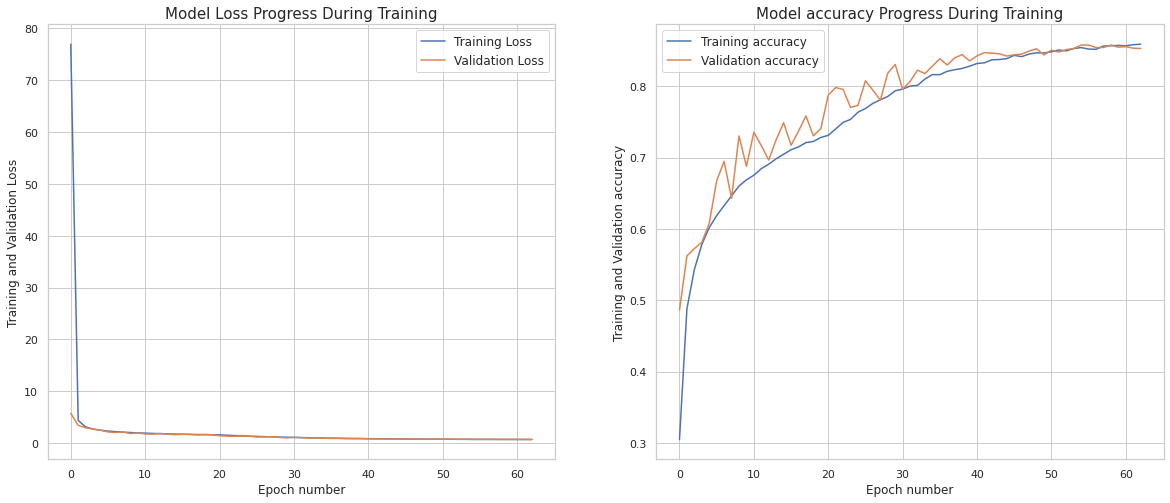

In [58]:
# plotting the validation and training loss and accuracy progress
plot_train_val_curves(history)

In [59]:
# Looking at the nurmerical values for the validation accuracy for
# the last 12 epochs (in decreasing order of epochs).
# We do this to understand the above curves better.

train_df = pd.DataFrame({
                        'validation accuracy': history.history['val_accuracy'],
                        'training accuracy': history.history['accuracy']
                         })
train_df.sort_index(ascending=False).head(12)

,validation accuracy,training accuracy
62,0.8530,0.859000
61,0.8534,0.858267
60,0.8556,0.856667
59,0.8548,0.857267
58,0.8578,0.856778
57,0.8544,0.856400
56,0.8542,0.851778
55,0.8578,0.852200
54,0.8578,0.854244
53,0.8530,0.852889


In [60]:
# print the model summary
# we use it to double check the consistency of the model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 96)        2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 96)        0         
_________________________________________________________________
local_response_normalization (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 384)       147840    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 384)       1536      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 384)         0         
_________________________________________________________________
local_response_normalization (None, 7, 7, 384)         0

# Testing the model on unseen data (test data)

In [61]:
# Colorful outputs
class bcolors:
    RED       = '\033[91m'
    OKBLUE    = '\033[94m'
    GREEN = '\033[32m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC      = '\033[0m'

In [62]:
# importing multiple evaluation functions from scikit learn
from sklearn.metrics import accuracy_score, classification_report

In [63]:
# predicting the classes corresponding to the test features
y_pred = model.predict(X_test)

# converting the hot encoded values into single digit class label
pred_labels = np.argmax(y_pred, axis=1) 
y_test_label = np.argmax(y_test, axis=1)
pred_labels, y_test_label

(array([3, 8, 8, ..., 5, 1, 7]), array([3, 8, 8, ..., 5, 1, 7]))

In [64]:
print(bcolors.BOLD + bcolors.OKBLUE +\
      "\nDETAILED TEST SUMMARY:"\
      + bcolors.ENDC + bcolors.ENDC)

# creating a list of label
target_names = ["airplane", "automobile", "bird", "cat", "deer",
                "dog", "frog", "horse", "ship", "truck"]

# Printing test scores and report
print(bcolors.BOLD + bcolors.GREEN +\
      '\n Test Accuracy: ' + bcolors.ENDC + bcolors.ENDC,
      accuracy_score(y_test_label, pred_labels))

print(bcolors.BOLD + bcolors.GREEN +\
      '\n Classification Report: \n ' + bcolors.ENDC + bcolors.ENDC,
      classification_report(y_test_label,
                            pred_labels,
                            target_names=target_names))


DETAILED TEST SUMMARY:

 Test Accuracy:  0.8503

 Classification Report: 
                precision    recall  f1-score   support

    airplane       0.87      0.85      0.86      1000
  automobile       0.89      0.95      0.92      1000
        bird       0.82      0.82      0.82      1000
         cat       0.76      0.69      0.72      1000
        deer       0.83      0.84      0.84      1000
         dog       0.87      0.70      0.77      1000
        frog       0.80      0.95      0.87      1000
       horse       0.87      0.89      0.88      1000
        ship       0.92      0.91      0.92      1000
       truck       0.87      0.91      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

